In [1]:
# Importing the required libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, LSTM
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('weatherstats_toronto_hourly.csv')
df.head(5)

,date_time_local,unixtime,pressure_station,pressure_sea,wind_dir,wind_dir_10s,wind_speed,wind_gust,relative_humidity,dew_point,...,windchill,humidex,visibility,health_index,cloud_cover_4,cloud_cover_8,cloud_cover_10,solar_radiation,max_air_temp_pst1hr,min_air_temp_pst1hr
0,2022-02-28 15:00:00 EST,1646078400,100.47,102.67,SSE,15.0,14,NaN,60.0,-12.9,...,-12.0,NaN,24100,NaN,NaN,8.0,NaN,NaN,-5.8,-6.6
1,2022-02-28 14:00:00 EST,1646074800,100.52,102.72,SE,13.0,9,NaN,51.0,-14.4,...,-10.0,NaN,24100,2.5,NaN,8.0,NaN,NaN,-5.5,-6.5
2,2022-02-28 13:00:00 EST,1646071200,100.63,102.83,SE,14.0,7,NaN,48.0,-15.6,...,-10.0,NaN,24100,2.5,NaN,7.0,NaN,NaN,-5.7,-7.1
3,2022-02-28 12:00:00 EST,1646067600,100.70,102.90,SE,13.0,11,NaN,46.0,-16.4,...,-12.0,NaN,24100,2.8,NaN,3.0,NaN,NaN,-6.4,-8.1
4,2022-02-28 11:00:00 EST,1646064000,100.70,102.91,N,1.0,4,NaN,44.0,-18.3,...,-10.0,NaN,24100,2.9,NaN,3.0,NaN,NaN,-8.0,-9.3


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5050 entries, 0 to 5049
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date_time_local      5050 non-null   object 
 1   unixtime             5050 non-null   int64  
 2   pressure_station     5050 non-null   float64
 3   pressure_sea         5050 non-null   float64
 4   wind_dir             4968 non-null   object 
 5   wind_dir_10s         5049 non-null   float64
 6   wind_speed           5050 non-null   int64  
 7   wind_gust            1032 non-null   float64
 8   relative_humidity    5049 non-null   float64
 9   dew_point            5049 non-null   float64
 10  temperature          5050 non-null   float64
 11  windchill            1524 non-null   float64
 12  humidex              772 non-null    float64
 13  visibility           5050 non-null   int64  
 14  health_index         5008 non-null   float64
 15  cloud_cover_4        0 non-null      f

In [4]:
df.isnull().sum()

date_time_local           0
unixtime                  0
pressure_station          0
pressure_sea              0
wind_dir                 82
wind_dir_10s              1
wind_speed                0
wind_gust              4018
relative_humidity         1
dew_point                 1
temperature               0
windchill              3526
humidex                4278
visibility                0
health_index             42
cloud_cover_4          5050
cloud_cover_8            56
cloud_cover_10         5050
solar_radiation        5050
max_air_temp_pst1hr      38
min_air_temp_pst1hr      38
dtype: int64

In [5]:
# Dropping columns that have more than 4/5th data missing, unixtime is dropped as date time is also there

df.drop(['unixtime','wind_gust','humidex', 'cloud_cover_4', 'cloud_cover_10', 'solar_radiation'], axis = 1, inplace = True)

In [6]:
# converting date_time_local from string to datetime type after removing EST

df['date_time_local'] = df['date_time_local'].apply(lambda x :x[:-3])
df['date_time_local'] = pd.to_datetime(df['date_time_local'])

In [7]:
# Checking for duplicate values 

df['date_time_local'].is_unique

False

In [8]:
# Dropping dupicate values

df.drop_duplicates(subset ="date_time_local",keep = False, inplace = True)
df['date_time_local'].is_unique

True

In [9]:
# Getting the year, month, day and hour from  the date_time_local

df['year'] = df['date_time_local'].dt.year
df['month'] = df['date_time_local'].dt.month
df['day'] = df['date_time_local'].dt.day
df['hour'] = df['date_time_local'].dt.hour

In [10]:
# function to fill in missing windchill, healthindex and cloudcover

def fill_wind_chill(month, w_chill):
    if np.isnan(w_chill):
        return avg_windchill[month]
    else:
        return w_chill
    
def fill_HI(month, HI):
    if np.isnan(HI):
        return avg_healthindex[month]
    else:
        return HI
    
def fill_cloudcover(month, cc):
    if np.isnan(cc):
        return avg_cc[month]
    else:
        return cc

In [11]:
# Calculating average windchill by month

avg_windchill = df.groupby('month').mean()['windchill']
avg_windchill

month
1    -15.453560
2    -13.362887
8           NaN
9           NaN
10          NaN
11    -5.659574
12    -7.515873
Name: windchill, dtype: float64

In [12]:
# As windchill is calculted for colder months only, set average windchill of other months as 0

avg_windchill.fillna(0, inplace=True)

In [13]:
# Calculating averagehealth index

avg_healthindex = df.groupby('month').mean()['health_index']
avg_healthindex

month
1     2.862687
2     2.903470
8     2.695792
9     2.037361
10    2.042722
11    2.539499
12    2.392713
Name: health_index, dtype: float64

In [14]:
#Calculating average cloudcover

avg_cc = df.groupby('month').mean()['cloud_cover_8']
avg_cc

month
1     4.907586
2     5.568504
8     4.286115
9     4.659249
10    5.986559
11    5.322670
12    6.276798
Name: cloud_cover_8, dtype: float64

In [15]:
# Applying functions to fill in missing valus in the dataframe

df['health_index'] = df.apply(lambda x: fill_HI(x['month'], x['health_index']), axis =1)
df['windchill'] = df.apply(lambda x: fill_wind_chill(x['month'], x['windchill']), axis=1)
df['cloud_cover_8'] = df.apply(lambda x: fill_cloudcover(x['month'], x['cloud_cover_8']), axis = 1)

In [16]:
# checking wind direction which is a categorical value

df['wind_dir'].unique()

array(['SSE', 'SE', 'N', 'NNE', 'NW', 'WNW', 'W', 'WSW', 'SW', 'NNW',
       'NE', 'ENE', 'E', 'ESE', 'S', 'SSW', nan], dtype=object)

In [17]:
#filling missing wind_dir values with the most frequent observations

mode = df['wind_dir'].mode().values[0]
df['wind_dir'] = df['wind_dir'].fillna(mode)

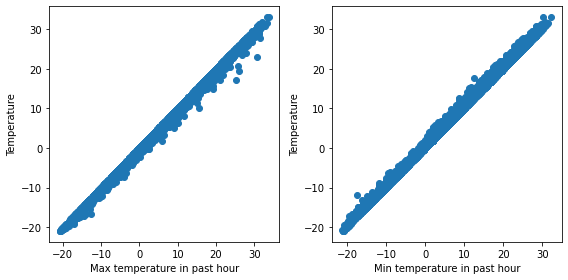

In [18]:
# Checking max_air_temp_pst1hr and min_air_temp_pst1hr against temperature to see linearity

fig, axes = plt.subplots(1, 2, figsize = (8,4))
axes[0].scatter(df['max_air_temp_pst1hr'], df['temperature'])
axes[1].scatter(df['min_air_temp_pst1hr'], df['temperature'])
axes[0].set_xlabel('Max temperature in past hour')
axes[1].set_xlabel('Min temperature in past hour')
axes[0].set_ylabel('Temperature')
axes[1].set_ylabel('Temperature')
fig.tight_layout()
plt.show()

In [19]:
# As they have a positive linear relationship with temperature, they are dropped

df.drop(['max_air_temp_pst1hr','min_air_temp_pst1hr'], axis = 1, inplace = True)

In [20]:
# checking again for null values

df.isnull().sum()

date_time_local      0
pressure_station     0
pressure_sea         0
wind_dir             0
wind_dir_10s         1
wind_speed           0
relative_humidity    1
dew_point            1
temperature          0
windchill            0
visibility           0
health_index         0
cloud_cover_8        0
year                 0
month                0
day                  0
hour                 0
dtype: int64

In [21]:
# dropping the remaining null rows

df = df.dropna()

<AxesSubplot:>

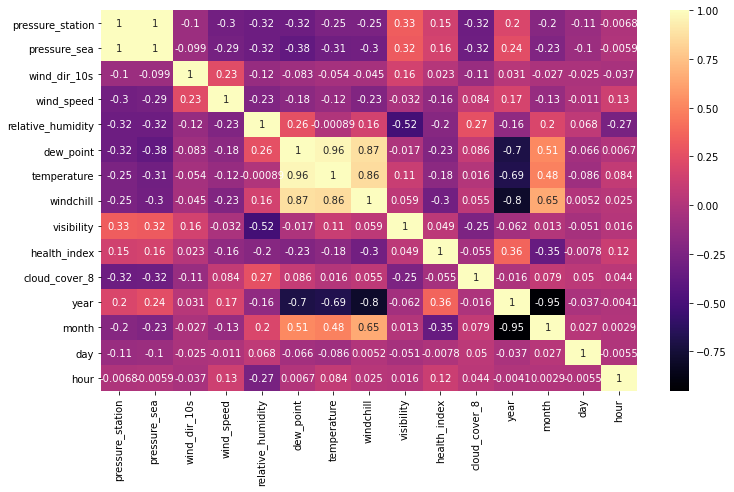

In [22]:
# Plotting a heatmap of the remaining variables

plt.figure(figsize=(12,7))
sns.heatmap(df.corr(), annot= True, cmap = 'magma')

In [23]:
# As pressure_station and pressure sea are perfectly corelated, one is dropped
# Also dew_point  and windchill have a very high corelation with temperature, therefore it is dropped

df =df.drop(['pressure_sea', 'dew_point', 'windchill'], axis = 1)

In [24]:
df.describe()

,pressure_station,wind_dir_10s,wind_speed,relative_humidity,temperature,visibility,health_index,cloud_cover_8,year,month,day,hour
count,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000
mean,99.558985,20.570155,15.824415,73.392390,7.078736,21610.879905,2.490568,5.290196,2021.279033,7.631986,15.733056,11.500595
std,0.730909,10.349537,9.003099,15.283207,11.824071,5969.712334,0.670306,2.791930,0.448568,4.024888,8.715949,6.917975
min,96.500000,0.000000,1.000000,30.000000,-21.000000,200.000000,1.000000,0.000000,2021.000000,1.000000,1.000000,0.000000
25%,99.090000,13.000000,9.000000,63.000000,-1.600000,24100.000000,2.100000,3.000000,2021.000000,2.000000,8.000000,6.000000
50%,99.550000,23.000000,14.000000,73.000000,5.600000,24100.000000,2.400000,6.276798,2021.000000,9.000000,16.000000,11.000000
75%,100.030000,29.000000,21.000000,84.000000,17.400000,24100.000000,2.900000,8.000000,2022.000000,11.000000,23.000000,17.000000
max,101.740000,36.000000,67.000000,100.000000,33.100000,80500.000000,5.500000,8.000000,2022.000000,12.000000,31.000000,23.000000


In [25]:
# Wind_dir has categorical variables, obtain dummy variable for them

df =pd.get_dummies(df, drop_first= True)

In [26]:
df.head(5)

,date_time_local,pressure_station,wind_dir_10s,wind_speed,relative_humidity,temperature,visibility,health_index,cloud_cover_8,year,...,wind_dir_NNW,wind_dir_NW,wind_dir_S,wind_dir_SE,wind_dir_SSE,wind_dir_SSW,wind_dir_SW,wind_dir_W,wind_dir_WNW,wind_dir_WSW
0,2022-02-28 15:00:00,100.47,15.0,14,60.0,-6.3,24100,2.90347,8.0,2022,...,0,0,0,0,1,0,0,0,0,0
1,2022-02-28 14:00:00,100.52,13.0,9,51.0,-5.9,24100,2.50000,8.0,2022,...,0,0,0,1,0,0,0,0,0,0
2,2022-02-28 13:00:00,100.63,14.0,7,48.0,-6.3,24100,2.50000,7.0,2022,...,0,0,0,1,0,0,0,0,0,0
3,2022-02-28 12:00:00,100.70,13.0,11,46.0,-6.8,24100,2.80000,3.0,2022,...,0,0,0,1,0,0,0,0,0,0
4,2022-02-28 11:00:00,100.70,1.0,4,44.0,-8.1,24100,2.90000,3.0,2022,...,0,0,0,0,0,0,0,0,0,0


In [27]:
print(list(df.columns))

['date_time_local', 'pressure_station', 'wind_dir_10s', 'wind_speed', 'relative_humidity', 'temperature', 'visibility', 'health_index', 'cloud_cover_8', 'year', 'month', 'day', 'hour', 'wind_dir_ENE', 'wind_dir_ESE', 'wind_dir_N', 'wind_dir_NE', 'wind_dir_NNE', 'wind_dir_NNW', 'wind_dir_NW', 'wind_dir_S', 'wind_dir_SE', 'wind_dir_SSE', 'wind_dir_SSW', 'wind_dir_SW', 'wind_dir_W', 'wind_dir_WNW', 'wind_dir_WSW']


In [28]:
# Obtaining temperature values for time series modelling

temp = df['temperature'].values
temp.shape

(5046,)

Text(0, 0.5, 'Temperature')

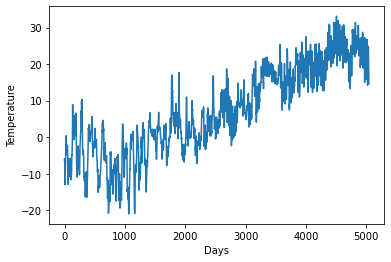

In [29]:
plt.plot(temp)
plt.xlabel('Days')
plt.ylabel('Temperature')

In [30]:
# Splitting into training and testing sets

train_size = int(len(temp) * 0.80)
test_size = len(temp)-train_size

train_data = temp[0:train_size]
test_data = temp[train_size:len(temp)]

In [31]:
train_size, test_size

(4036, 1010)

In [32]:
# Creating timeseries dataset for training

def create_timeseries(dataset, time_step=1):
    
    X = []
    Y = []
    
    for i in range(len(dataset)-time_step-1):
        
        a = dataset[i:(i+time_step)]   
        X.append(a)
        Y.append(dataset[i + time_step])
        
    return np.array(X), np.array(Y)

In [33]:
time_step = 6
X_train, y_train = create_timeseries(train_data, time_step)
X_test, y_test = create_timeseries(test_data, time_step)

In [34]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4029, 6)
(4029,)
(1003, 6)
(1003,)


In [35]:
# Reshaping for LSTM

X_train =X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)     

In [36]:
print(X_train.shape)
print(X_test.shape)

(4029, 6, 1)
(1003, 6, 1)


In [37]:
# Creating the LSTM Model

lstm = Sequential()
lstm.add(LSTM(64, input_shape = (time_step, 1), return_sequences = True))
lstm.add(LSTM(32, return_sequences = True))
lstm.add(LSTM(16))
lstm.add(Dense(1, activation = 'linear'))

In [38]:
# Model Compiling and training

lstm.compile(loss='mean_squared_error', optimizer='adam')
lstm.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=64, verbose=2)


Epoch 1/100
51/51 - 8s - loss: 41.3777 - val_loss: 182.9315
Epoch 2/100
51/51 - 1s - loss: 21.6909 - val_loss: 138.3557
Epoch 3/100
51/51 - 1s - loss: 13.6527 - val_loss: 110.1031
Epoch 4/100
51/51 - 1s - loss: 9.5919 - val_loss: 93.5759
Epoch 5/100
51/51 - 1s - loss: 7.3283 - val_loss: 81.3551
Epoch 6/100
51/51 - 1s - loss: 5.9211 - val_loss: 71.8950
Epoch 7/100
51/51 - 1s - loss: 4.8873 - val_loss: 64.1586
Epoch 8/100
51/51 - 1s - loss: 4.1000 - val_loss: 57.4507
Epoch 9/100
51/51 - 1s - loss: 3.5122 - val_loss: 51.7459
Epoch 10/100
51/51 - 1s - loss: 3.0679 - val_loss: 47.1711
Epoch 11/100
51/51 - 1s - loss: 2.6853 - val_loss: 43.0395
Epoch 12/100
51/51 - 1s - loss: 2.3795 - val_loss: 39.4830
Epoch 13/100
51/51 - 1s - loss: 2.1614 - val_loss: 36.2245
Epoch 14/100
51/51 - 1s - loss: 1.9361 - val_loss: 33.3045
Epoch 15/100
51/51 - 1s - loss: 1.7746 - val_loss: 30.9040
Epoch 16/100
51/51 - 1s - loss: 1.6262 - val_loss: 28.6461
Epoch 17/100
51/51 - 1s - loss: 1.4964 - val_loss: 26.6712


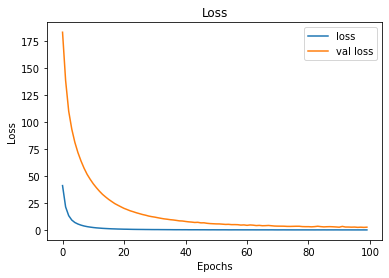

In [39]:
# Plotting training and validation losses

plt.plot(lstm.history.history['loss'], label = 'loss')
plt.plot(lstm.history.history['val_loss'], label = 'val loss')
plt.title('Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [40]:
# Predictions using trained lstm model

test_pred = lstm.predict(X_test)

In [41]:
# Test RMSE

test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
print('Test RMSE: %.2f' % (test_rmse))

Test RMSE: 5.29


LSTM gives an okay performance.

In [42]:
# Also implementing a Linear Regression model for comparison

from sklearn.linear_model import LinearRegression

In [43]:
X = df.drop(['date_time_local', 'temperature'], axis=1).values
y = df['temperature'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

In [44]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
pred = linreg.predict(X_test)

In [45]:
rmse = np.sqrt(mean_squared_error(pred, y_test))
rmse

4.258214581340512

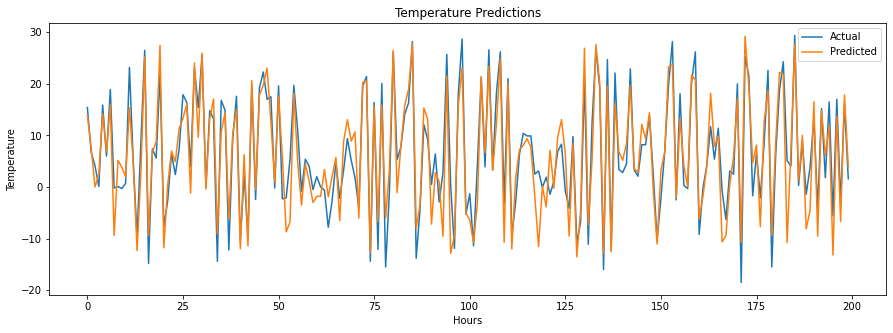

In [47]:
# Plotting actual vs predicted temperature

plt.figure(figsize=(15,5))
plt.plot(y_test[:200], label = 'Actual')
plt.plot(pred[:200], label = 'Predicted')
plt.title('Temperature Predictions')
plt.xlabel('Hours')
plt.ylabel('Temperature')
plt.legend()
plt.show()

Well, it seems like the Linear Regression performs better!